# Computational Graphs - Signed Distance Functions and Particle Physics
*Christoph Heindl 2017, https://github.com/cheind/py-cgraph/*

This is part four in series about computational graphs and their applications. In the first two parts the fundamental concepts of symbolic computation and especially automatic derivative calculus were covered. 

This part introduces signed distance functions and applies them in the context of particle physics. As we will see, signed distance functions provide an algebraic way to quickly model environments that can be used for efficient collision tests and responses.

As always Python 3.x knowledge is assumed. I'm also assuming familiarity with physical based animations. If you need a head start on particle physics you might want to get a copy of 'Foundations of Physically based Modeling & Animation'. Full code of everything developed in this notebook is provided in CGraph's [repository][7].

Before we dive in, here's a preview of what we will end up with (click the image to view on Youtube, or scroll down to view in notebook).
[![](images/particle_physics.gif)](https://www.youtube.com/watch?v=N_R7vjEWFWs])



## Signed Distance Functions

[Signed distance functions][1] (SDF) are functions that map from spatial locations to surface distances $f:\mathbb {R} ^{n}\to \mathbb {R}$. Given a location in Euclidean space the signed distance function will tell the distance to the closest surface. The attribute *Signed* comes from the fact that surfaces define outside and inside relations. In this work we will use the convention that negative distance values are associated with locations inside of surfaces and positive values correspond to regions outside of any surface. While signed distance functions work in any spatial dimensions, we will restrict ourself to two dimensions.

Beside distance queries, signed distance functions also offer another useful property: gradients. The gradient is the derivative with respect to the spatial coordinates $\vec\nabla f$. It forms a vector that points in the direction of fastest distance ascent.

SDFs have a wide range of applications in computer science. They are used for [glyph rendering][2], [surface reconstruction][3], [model rendering][4]. In this notebook they will be used for collision test and response, similar to what is described in [rapid collision detection][5]. Also, NVidia's [Flex technology][6] supports collisions with static environments given as signed distance fields (field here refers to a discretization of the SDF using regular grids). 

During the course of this work we will develop a particle simulation based on Newton's second law. Particles will interact with their environment that will be defined by a SDF. The SDF will help in the following ways
- the value of $f$ will be used to detect collisions
- the gradient $\vec\nabla f$ will be used for collision response

Signed distance functions are algebraic functions, so we can express them symbolically in Python using CGraph. First, we will define so called leaf nodes or primitives, such as circles and half-spaces. These primitives are building blocks for more complex environments to be modelled with SDF. Next, we will define operations on primitives that will allow us to join primitives, slowly allowing us to build more and more complex SDFs.

[1]: https://en.wikipedia.org/wiki/Signed_distance_function
[2]: http://www.valvesoftware.com/publications/2007/SIGGRAPH2007_AlphaTestedMagnification.pdf
[3]: https://www.microsoft.com/en-us/research/project/kinectfusion-project-page/
[4]: http://advances.realtimerendering.com/s2015/DynamicOcclusionWithSignedDistanceFields.pdf
[5]: http://cg.cs.uni-bonn.de/project-pages/hairmodeling/documents/RapidCollisonDetection.pdf
[6]: http://docs.nvidia.com/gameworks/content/gameworkslibrary/physx/flex/manual.html
[7]: https://github.com/cheind/py-cgraph



In [1]:
import cgraph as cg
import cgraph.sdf as sdf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
np.seterr(all='ignore');

### Primitives

#### Circle
The first building block is a circle. Given the circle center $c_x$, $c_y$ and its radius $r$, the SDF for a circle can be formulated as

$$f(x,y) := \sqrt{(x-c_x)^2 + (y-c_y)^2} - r$$

$f$ computes the distance of the point given by ($x$,$y$) to the circle center and subracting the radius from it. It is easy to see the points inside the circle will have negative distance values, points on the circle will have distance 0 and points outside will be assigned positive distance values.

That formula translates naturally to symbolic Python

In [2]:
def circle(center=[0,0], radius=1.):
    x = cg.Symbol('x')
    y = cg.Symbol('y')
    f = cg.sym_sqrt((x - center[0])**2 + (y - center[1])**2) - radius
    return cg.Function(f, [x,y])

c = circle()

# Evaluate c 
c(0,0), c(1,0), c(100,100)

(array([-1.]), array([ 0.]), array([ 140.42135624]))

In case you haven't noticed, the definition of `circle` produces a symbolic equation, which looks like this

In [3]:
c.f

(sqrt(((x - 0)**2 + (y - 0)**2)) - 1.0)

The way we will be visualizing signed distance functions is by contour plots. Each line in a contour plot represents a constant signed distance value. [sdf.py][1] already comes with this functionality built-in and will be using it here. Below are three plots generated from `c`. First one on the left shows the zero-interface of the circle, in the middle more iso-levels are shown and finally to the right we plot how gradients flow.

[1]: ../cgraph/sdf.py

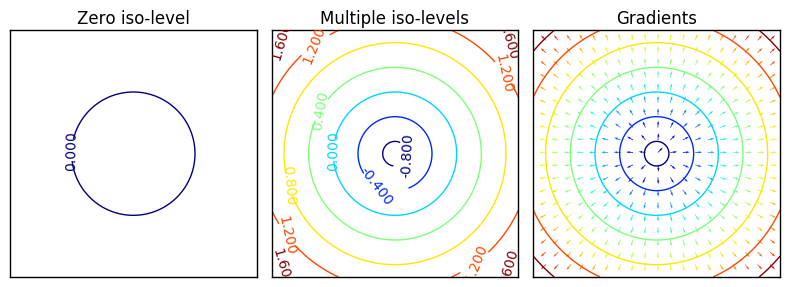

In [4]:
fig, (ax0,ax1,ax2) = plt.subplots(1,3,figsize=(8,8))
sdf.plot_sdf(fig, ax0, c, show_isolines='zero', show_isolabels=True, show_quiver=False); ax0.set_title('Zero iso-level')
sdf.plot_sdf(fig, ax1, c, show_isolines='all', show_isolabels=True, show_quiver=False); ax1.set_title('Multiple iso-levels')
sdf.plot_sdf(fig, ax2, c, show_isolines='all', show_isolabels=False, show_quiver=True); ax2.set_title('Gradients')
plt.tight_layout()

#### Half-space

The next building block is the so called half-space. In 2D this corresponds to an infinite line that splits space into outside and inside. We will represent the half-space in [Hessian normal form][1] requiring an oriented line normal ($n_x$,$n_y$) and distance from origin $d$

$$f(x,y) := x*n_x + y*n_y - d$$

In symbolic Python

[1]: [http://mathworld.wolfram.com/HessianNormalForm.html]

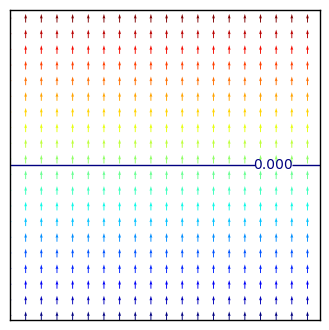

In [5]:
def halfspace(normal=[0,1], d=0):
    n = normal / np.linalg.norm(normal) # Ensure unit length
    x = cg.Symbol('x')
    y = cg.Symbol('y')
    f = x * n[0] + y * n[1] - d
    return cg.Function(f, [x,y])

h = halfspace()

fig, ax = plt.subplots()
sdf.plot_sdf(fig, ax, h, show_isolabels=True, show_isolines='zero');

There are many more primitives you can build. See [Ingo's page][1] for some ideas. We, however, stop at this point and move on to operations that allow us to join primitives.

### Operations

The operations implemented here are so called set operations. They allow us to union, intersect, subtract primitives from each other, thereby generate new and more complex distance fields.

#### Union

This operation takes two SDFs and joins them in a way that the result represents the union of both. Mathematically this operation can be forumulated as 

$$f(x,y;f_0,f_1) := \min(f_0(x,y), f_1(x,y))$$

Here $f_0$ and $f_1$ are two separate signed distance functions. In code we get

[1]: http://iquilezles.org/www/articles/distfunctions/distfunctions.htm

In [6]:
def union(f0, f1):
    x = cg.Symbol('x')
    y = cg.Symbol('y')    
    f = cg.sym_min(f0.f, f1.f)
    
    return cg.Function(f, [x,y])

#### Intersection

This operation takes two SDFs and joins them in a way that the result represents the intersection of both. Mathematically this operation can be formulated as 

$$f(x,y;f_0,f_1) := \max(f_0(x,y), f_1(x,y))$$

Here's the associated Python code

In [7]:
def intersection(f0, f1):
    x = cg.Symbol('x')
    y = cg.Symbol('y')    
    f = cg.sym_max(f0.f, f1.f)
    
    return cg.Function(f, [x,y])

#### Difference

Finally, the difference operator subtracts one SDF from another.

$$f(x,y;f_0,f_1) := \max(f_0(x,y), -f_1(x,y))$$

Note the negative sign `-` at $-f_1$.

In [8]:
def difference(f0, f1):
    x = cg.Symbol('x')
    y = cg.Symbol('y')    
    f = cg.sym_max(f0.f, -f1.f)
    
    return cg.Function(f, [x,y])

Below we illustrate the effect of the operations on two circles.

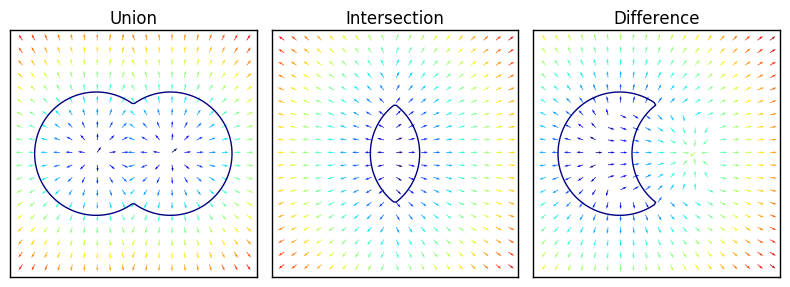

In [9]:
c0 = circle(center=[-0.6, 0])
c1 = circle(center=[0.6, 0])

u = union(c0, c1)
i = intersection(c0, c1)
d = difference(c0, c1) # Pac-man, here we come

fig, (ax0,ax1,ax2) = plt.subplots(1, 3, figsize=(8,8))
sdf.plot_sdf(fig, ax0, u, show_isolines='zero'); ax0.set_title('Union')
sdf.plot_sdf(fig, ax1, i, show_isolines='zero'); ax1.set_title('Intersection')
sdf.plot_sdf(fig, ax2, d, show_isolines='zero'); ax2.set_title('Difference')
plt.tight_layout()

### Introducing `cgraph.sdf`

As already mentioned, CGraph comes with an SDF implementation on its own which is very similar to what has been introduced above, but provides more advanced functionality that shall be introduced here. In case you are interested have a look at.

#### A domain language for modeling
`cgraph.sdf` comes with a custom domain specific language for modeling signed distance functions. You can use `|` for union, `&` for intersection and `-` for difference as shown below.

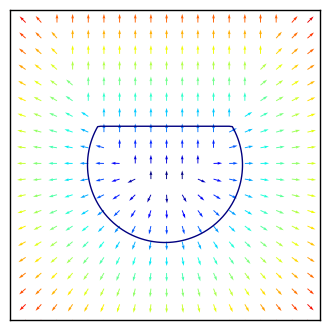

In [10]:
f = sdf.Circle() & sdf.Halfspace(normal=[0,1], d=0.5)

fig, ax = plt.subplots()
sdf.plot_sdf(fig, ax, f, show_isolines='zero');

Additionally, properties can be used to temporarily affect modelling operations. `sdf.smoothness` allows you to temporarily control the smoothness of operations.

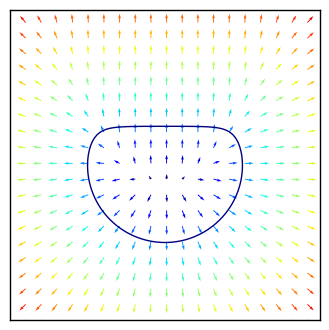

In [11]:
with sdf.smoothness(10):
    f = sdf.Circle() & sdf.Halfspace(normal=[0,1], d=0.5)

fig, ax = plt.subplots()
sdf.plot_sdf(fig, ax, f, show_isolines='zero');

Similarily `sdf.transform` allows setting of a displaced coordinate system for newly created elements

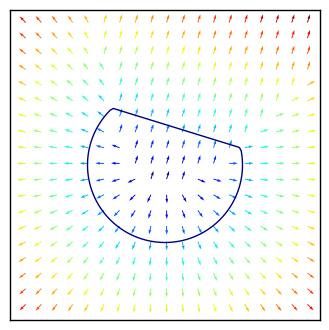

In [12]:
with sdf.transform(angle=-0.3):
    f = sdf.Circle() & sdf.Halfspace(normal=[0,1], d=0.5)
    
fig, ax = plt.subplots()
sdf.plot_sdf(fig, ax, f, show_isolines='zero');

These properties can be combined to generate quite complex worlds

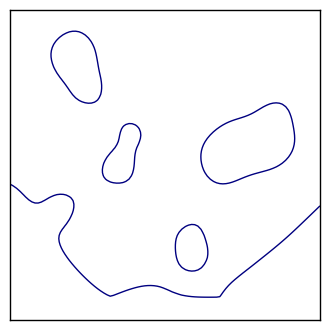

In [13]:
def random_box():
    """Returns a random box."""
    return sdf.Box(
        minc=np.random.uniform(-0.3, -0.1, size=2), 
        maxc=np.random.uniform(0.1, 0.3, size=2)
    )

def random_transform():
    """Returns a random transformation."""
    return sdf.transform(
        angle=np.random.uniform(-0.8, 0.8), 
        offset=np.random.uniform(-2, 2, size=2)
    )

f = sdf.Halfspace(normal=[0, 1], d=-1.8) | sdf.Halfspace(normal=[1, 1], d=-1.8) | sdf.Halfspace(normal=[-1, 1], d=-1.8)
for i in range(20):
    with random_transform(), sdf.smoothness(5):
        f |= random_box()
            
fig, ax = plt.subplots()
sdf.plot_sdf(fig, ax, f, show_quiver=False, show_isolines='zero');

## Particle Physics

Now that we are able to create worlds through the usage of signed distance functions, we can turn our attention towards particle physics and animation. In what we will developer particles represented as circle with happily interact with their environments represented by SDFs. Neither will particles interact with each, nor will they expose any rotational behavior.

We'll start by creating a particle simulation class first. The particle simulation is used together with an animation function  from ´cgraph.app.particle_physics' to visualize the particle behaviour.

In [14]:
import cgraph.app.particle_physics as phys
from matplotlib.collections import PatchCollection

### ParticleSimulation

The class `SimpleParticleSimulation` will be the main class responsible for moving and drawing the particles. We will first present a mock class and plug in the missing functions as we go.

In [15]:
class SimpleParticleSimulation:
    """Particle physics simulation."""
    
    def __init__(self, sdf, n=10, timestep=1/30):        
        self.n = n
        self.dt = timestep
        self.sdf = sdf       
        self.t = 0
        self.drawable = None
        
    def reset(self, ax):
        """Called by the animation module when restarting the simulation."""
        pass
        
    def update(self, ax, use_wall_time=False):
        """Called by the animation module to forward simulation by timestep seconds."""
        pass        
    
    def handle_collisions(self):
        """Will be called from update to handle and resolve collisions."""
        pass

First, the `reset` method is presented. It creates a list of particles and attributes.

In [16]:
def reset(self, ax):
    """Called by the animation module when restarting the simulation."""
    self.t = 0
        
    # Initialize particles
    self.p = np.zeros(self.n, dtype=[
            ('x', float, 2), # Position x,y
            ('v', float, 2), # Velocity vx,vy
            ('m', float, 1), # Mass
            ('r', float, 1)  # Radius
        ])

    # Randomized start values
    self.p['x'] = np.random.multivariate_normal([0, 1.5], [[0.05, 0],[0, 0.05]], self.n)
    self.p['v'] = np.random.multivariate_normal([0, 0], [[0.1, 0],[0, 0.1]], self.n)
    self.p['m'] = np.random.uniform(1, 10, size=self.n)
    self.p['r'] = self.p['m'] * 0.01

    # Visualization as a collection of circles
    if self.drawable:
        self.drawable.remove()        

    actors = [plt.Circle((0,0), radius=self.p['r'][i]) for i in range(self.n)]        
    self.drawable = ax.add_artist(PatchCollection(actors, offset_position='data', alpha=0.6, zorder=10))
    self.drawable.set_array(np.random.rand(len(actors)))
    
SimpleParticleSimulation.reset = reset

Next, `update` is responsible for stepping the simulation in time. Based on Newton's second law $a=\frac{f}{m}$ the state dynamics of particles are computed. Explicit Euler integration is then used to advance by `dt`.

In [17]:
def update(self, ax, use_wall_time):  
    """Called by the animation module to forward simulation by timestep seconds."""
    
    # Assumed here that the only force acting is gravity
    f = self.p['m'][:, np.newaxis] * np.array([0, -1])

    # Compute the dynamics
    dx = self.p['v']                    # dx/dt = dv
    dv = f / self.p['m'][:, np.newaxis] # dv/dt = force / mass

    # Integrate using explicit Euler towards time t + dt
    self.p['x'] += dx * self.dt
    self.p['v'] += dv * self.dt

    self.handle_collisions()

    self.t += self.dt        
    self.drawable.set_offsets(self.p['x'])
    return self.drawable,

SimpleParticleSimulation.update = update

`cgraph.app.particle_physics` contains code for animating simulations. The code below shows how it can be used.

In [18]:
# SDF world
f = sdf.Halfspace(normal=[0, 1], d=-1.8) | sdf.Halfspace(normal=[1, 1], d=-1.8) | sdf.Halfspace(normal=[-1, 1], d=-1.8)

# Instance of the simulation
sp = SimpleParticleSimulation(f, n=10, timestep=1/30)

def run_animation(f, simulation, frames=300):
    """Run particle simulation and visualize result."""
    fig, ax = plt.subplots()
    sdf.plot_sdf(fig, ax, f, show_quiver=False, show_isolines='zero');
    plt.close()
    anim = phys.create_animation(fig, ax, simulation, frames=frames, repeat=True, use_wall_time=False)
    return anim.to_html5_video()

from IPython.display import HTML
HTML(run_animation(f, sp, frames=100))

As you can see the particles seem to be attracted by gravity, but they don't yet interact with the SDF environment. This will be changed next.

In an initial attempt, we will detect collisions and bring colliding particles to an immediate stop. Particles in collision can be easily detected by having a signed distance value equal to or less than zero. Since simulation runs on finite timesteps, it will happen that fast particles penetrate the SDF surface more than others. So, instead of simply stopping them on collision, we push them outside the colliding surface. Here's how this is done: The SDF gradient tells us the direction of fastest distance ascent. So, by moving each particle *pentretation depth* units along the gradient of the SDF at the collision location, we will place them at the zero interface of the SDF.

In [19]:
def handle_collisions(self):
    # Evaluate the SDF at updated particle positions
    d, grads = self.sdf(self.p['x'][:, 0], self.p['x'][:, 1], compute_gradient=True)
    
    # Account for radius of particles
    d -= self.p['r']
    
    # Get ids of colliding particles
    cids = np.where(d <= 0)[0]
    
    # Stop particles
    self.p['x'][cids] -= d[cids, np.newaxis] * grads[cids]
    self.p['v'][cids] = 0

# Monkey patch method
SimpleParticleSimulation.handle_collisions = handle_collisions

What's interesting in `handle_collisions_and_stop` is the usage of the SDF. First it is used to find any colliding particles. The SDF value gives us something similar to penetration depth. It is used later to correct the particle position by moving it along the gradient for `d` units, so that gets into an uncolliding state with the surface. This approach works no matter how complex your SDF is. Simulation below

In [20]:
f = sdf.Halfspace(normal=[0, 1], d=-1.8) | sdf.Halfspace(normal=[1, 1], d=-1.8) | sdf.Halfspace(normal=[-1, 1], d=-1.8)
sp = SimpleParticleSimulation(f, n=10, timestep=1/30)
HTML(run_animation(f, sp, frames=120))

`cgraph.app.particle_physics` a more realisitic collision model that supports 'bouncy' collisions. Besides, multiple forces are support. So we will start using it here for better effects. 

In [ ]:
f = sdf.Halfspace(normal=[0, 1], d=-1.8) | sdf.Halfspace(normal=[1, 1], d=-1.8) | sdf.Halfspace(normal=[-1, 1], d=-1.8)
with sdf.smoothness(10):
    f |= sdf.Circle(center=[0, 0.0], radius=0.5) & sdf.Halfspace(normal=[0.1, 1], d=0.3)
    
def gravity(p, t):
    """Close to planet surface gravity."""
    return p['m'][:, np.newaxis] * np.array([0, -1]) 

ps = phys.ParticleSimulation(f, n=100, timestep=1/30)
ps.force_generators += [gravity]

# Setup animation and run
HTML(run_animation(f, ps))

Once you make your SDF more and more complex, you will notice that your simulation becomes slower and slower. This is mostly due to the fact that the SDF takes longer to evaluate. To tackle this, `cgraph.app.particle_physics` provides `GridSDF` that samples the SDF at a regular grid and uses the grid information to interpolate queries. Here is how it works

In [ ]:
bounds=[(-2,2), (-2,2)] # World bounds to sample
g = sdf.GridSDF(f, bounds=bounds, samples=[400j, 400j])

ps = phys.ParticleSimulation(g, n=2000, timestep=1/30)
ps.force_generators += [gravity]

HTML(run_animation(g, ps, frames=500))